In [42]:
from sklearn.metrics import accuracy_score
import numpy as np
from detect_outlier import *
from sklearn.model_selection import train_test_split
from support_function.reporting import reporting


In [43]:
df_normalized = read_data()
df_normalized.dropna(inplace=True)


In [44]:
def score(label):
    if label == 0:
        return np.random.randint(300, 580)
    if label == 1:
        return np.random.randint(580, 670)
    if label == 2:
        return np.random.randint(670, 740)
    if label == 3:
        return np.random.randint(740, 800)
    if label == 4:
        return np.random.randint(800, 850)


def labeling(scores):
    label = []
    for score in scores:
        if score < 580:
            label.append(0)
        elif score >= 580 and score < 670:
            label.append(1)
        elif score >= 670 and score < 740:
            label.append(2)
        elif score >= 740 and score < 800:
            label.append(3)
        elif score >= 800:
            label.append(4)
    return np.array(label)

In [45]:
X = np.array(df_normalized[
    [
        "totalAsset",
        "averageTotalAsset",
        "frequencyMountOfTransaction",
        "borrow_per_balance",
        "deposit_per_asset",
        "borrow_per_deposit",
        "totalValueOfLiquidation",
        "numberOfLiquidation",
        "frequencyOfTransaction",
        "frequencyOfDappTransactions",
        "numberOfInteractedDapps",
        "typesOfInteractedDapps",
        "numberOfReputableDapps",
        "age",
    ]
].values)
first_y = df_normalized["1st_label"].values
second_y = df_normalized["2nd_label"].values

X_train, X_test, first_y_train, first_y_test, second_y_train, second_y_test = train_test_split(
    X, first_y, second_y, stratify=first_y, test_size=0.2, random_state=40
)
# Chuẩn bị dữ liệu

In [46]:
# def new_error_func(y, second_y, y_pred):
#     errors = [0] * len(y_pred)
#     # Lặp qua từng phần tử trong mảng
#     for i in range(len(y_pred)):
#         if y[i] > second_y[i]:
#             errors[i] = y_pred[i] - y[i]
#         else:
#             errors[i] = y_pred[i] - second_y[i]
#     return errors


def new_error_func(y, second_y, y_pred):
    errors = [0] * len(y_pred)
    for i in range(len(y_pred)):
        if y[i] == second_y[i]:
            errors[i] = y_pred[i] - y[i]
        else:
            min_value = min(y[i], second_y[i])
            max_value = max(y[i], second_y[i])
            if y_pred[i] <= min_value:
                errors[i] = y_pred[i] - min_value
            if y_pred[i] >= max_value:
                errors[i] = y_pred[i] - max_value
    return errors


# Hàm tính gradient của hàm lỗi (MSE)
def gradient_mean_squared_error(X, y, second_y, w):
    n = len(y)
    y_pred = labeling(np.dot(X, w))
    # error = y_pred - y
    error = new_error_func(y, second_y, y_pred)
    gradient = 2 * np.dot(X.T, error) / n
    return gradient


# Gradient descent để tối ưu hóa hàm lỗi (MSE)
def adam(
    X,
    y,
    second_y,
    learning_rate=0.01,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    num_iterations=1000,
):
    # Khởi tạo vector trọng số ngẫu nhiên
    w = np.random.uniform(0, 1, X.shape[1])
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    t = 0

    for _ in range(num_iterations):
        random_index = np.random.randint(0, len(X))
        X_sample = X[random_index : random_index + 1]
        y_sample = y[random_index : random_index + 1]
        second_y_sample = second_y[random_index : random_index + 1]

        # Tính gradient của hàm lỗi cho mẫu đã chọn
        grad = gradient_mean_squared_error(X_sample, y_sample, second_y_sample, w)

        # Tính trung bình độ lớn của gradient và gradient bình phương
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad**2)

        # Bias correction
        m_hat = m / (1 - beta1 ** (t + 1))
        v_hat = v / (1 - beta2 ** (t + 1))

        w -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        t += 1

    return w


learned_weights = adam(X_train, first_y_train, second_y_train)

print("Vector trọng số tối ưu:", learned_weights)

Vector trọng số tối ưu: [-0.01158497  0.18877859 -0.17879103 -0.04846014 -0.01551048  0.04564412
  0.3797507   0.34182354 -0.00835613 -0.11023552 -0.04846086  0.51057077
 -0.24442206 -0.01046619]


In [47]:
def new_accuracy(y_train, second_y_train, y_pred):
    y_train = np.array(y_train)
    second_y_train = np.array(second_y_train)
    y_pred = np.array(y_pred)
    first_label_count = np.sum(y_pred == y_train)
    condition = np.logical_or(y_pred == second_y_train, y_pred == y_train)
    count = np.sum(condition)
    accuracy = count / len(y_train)
    return accuracy, first_label_count, count - first_label_count

In [48]:
max1 = 0
res = None
for i in range(1000):
    learned_weights = adam(X_train, first_y_train, second_y_train)
    pred = labeling(X_test.dot(learned_weights))
    acc, _, __ = new_accuracy(first_y_test, second_y_test, pred)
    if acc > max1:
        max1 = acc
        res = learned_weights

In [49]:
print(max1, res)

0.9038394262725206 [ 0.30654464  0.07307854  0.29424592 -0.02231345  0.00399164  0.11743077
  0.11356262  0.28213307 -0.02602661  0.15411817 -0.15014247 -0.07987222
  0.0738793   0.05292735]


In [50]:
predicted_labels = labeling(X_test.dot(res))
print(new_accuracy(first_y_test, second_y_test, predicted_labels))

(0.9038394262725206, 20009, 660)


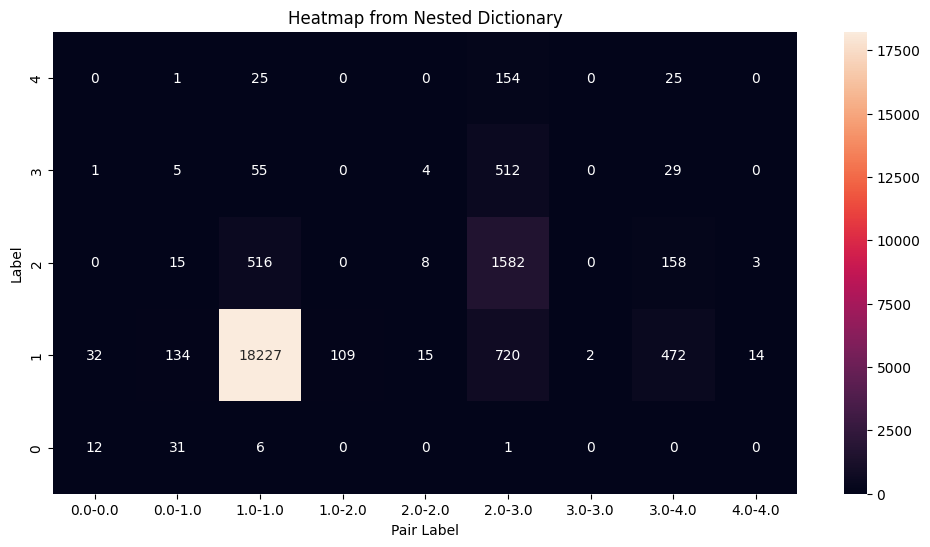

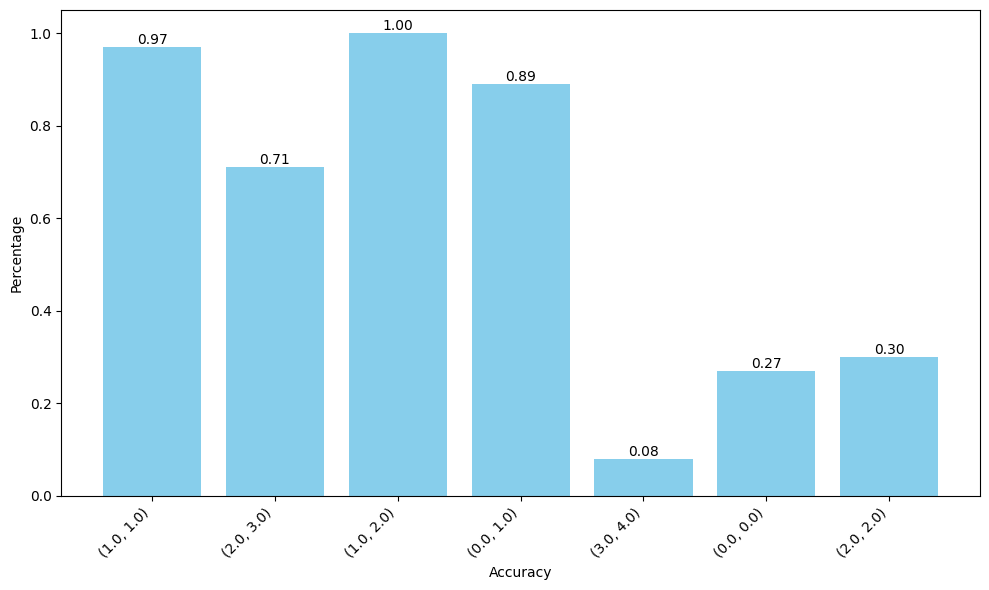

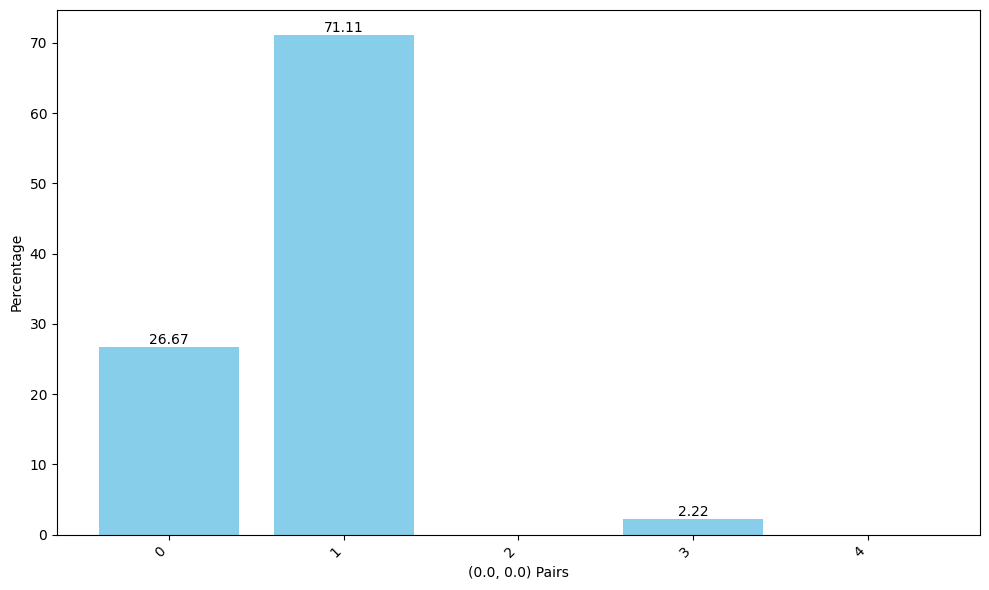

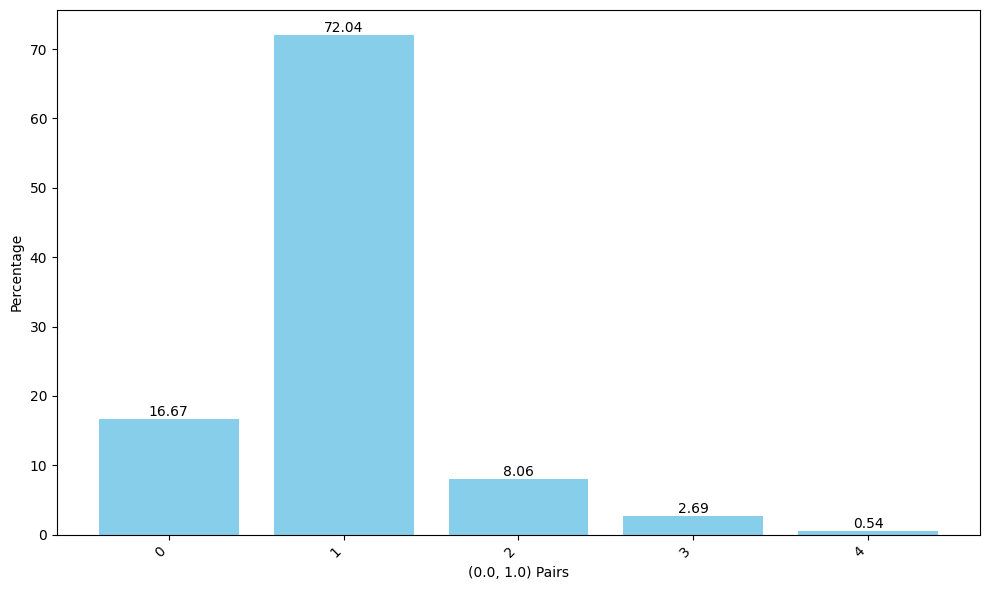

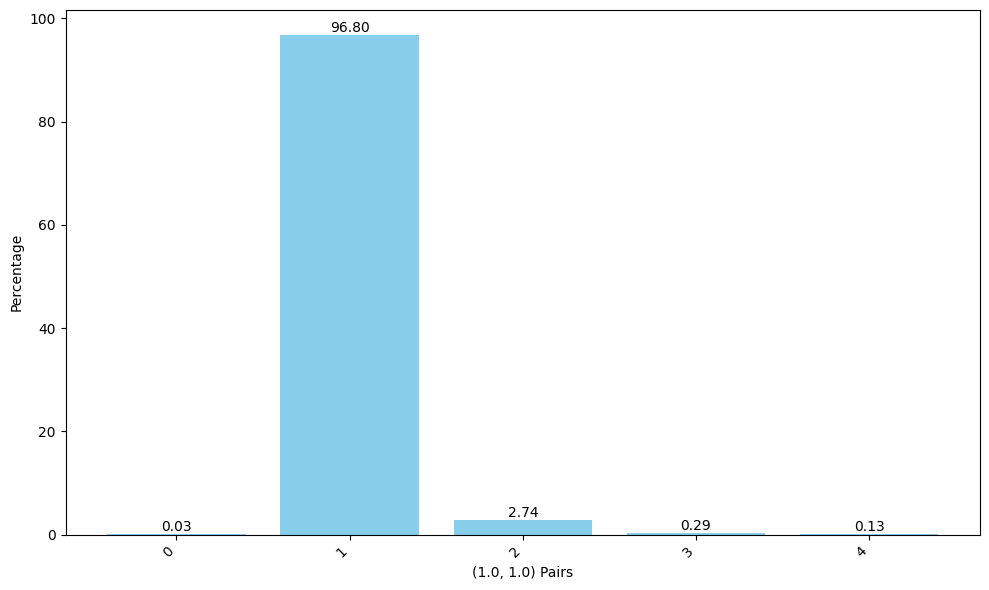

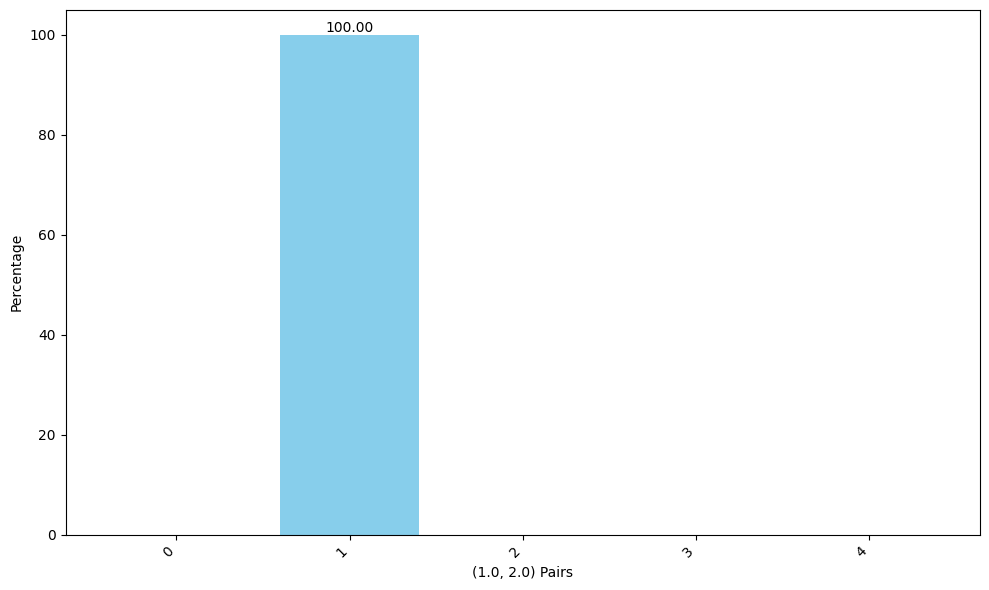

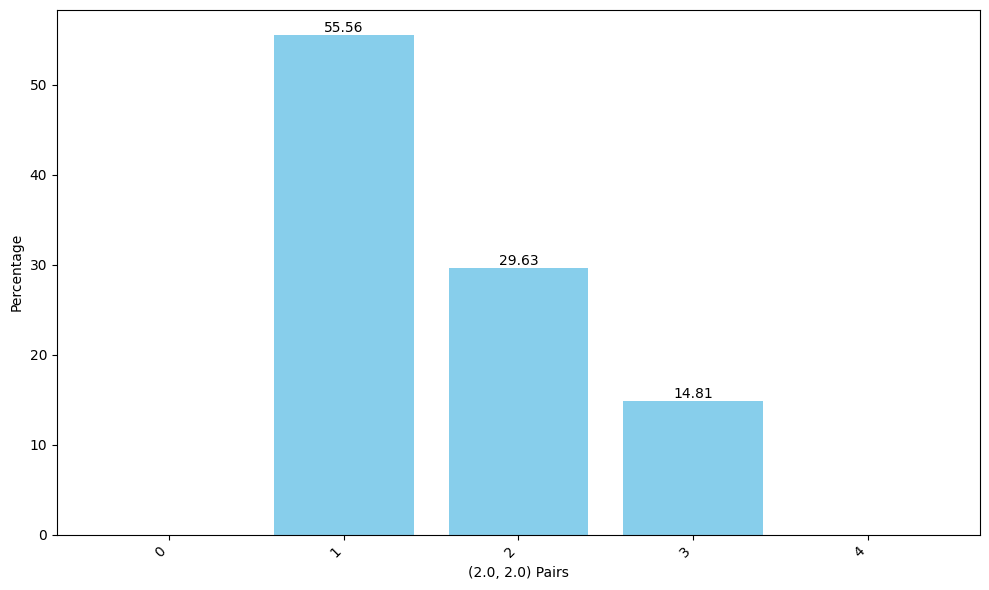

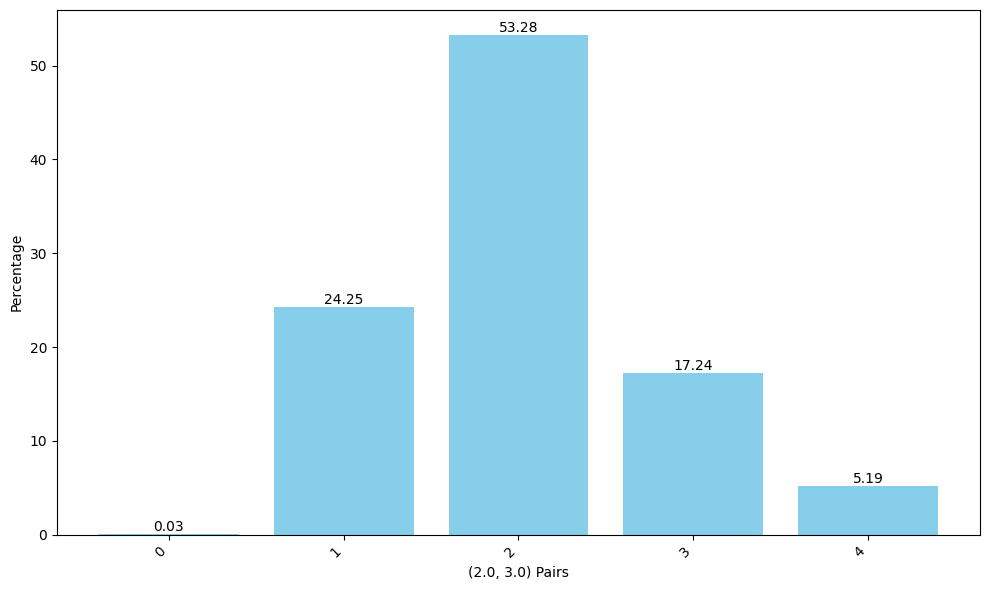

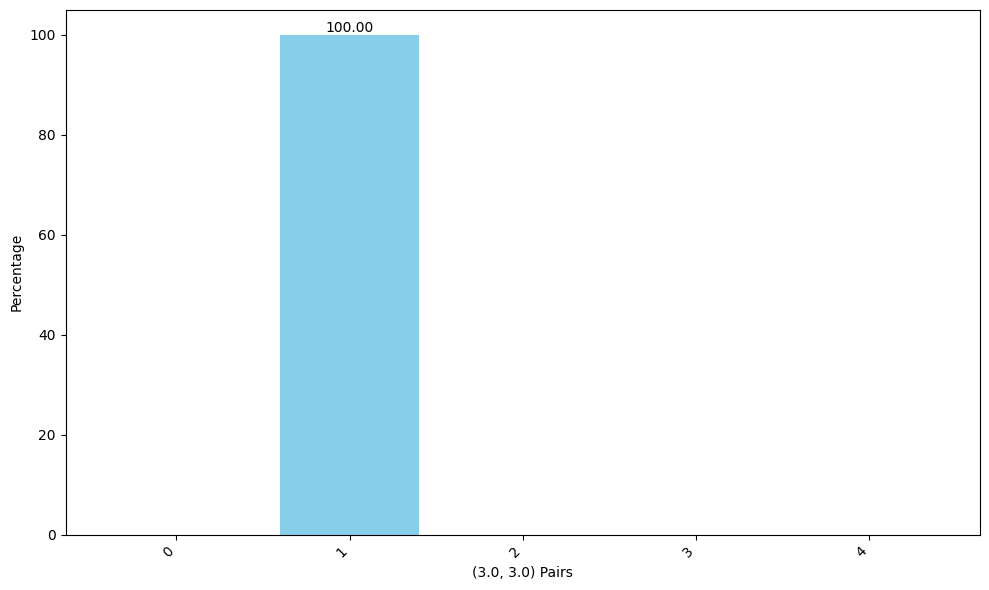

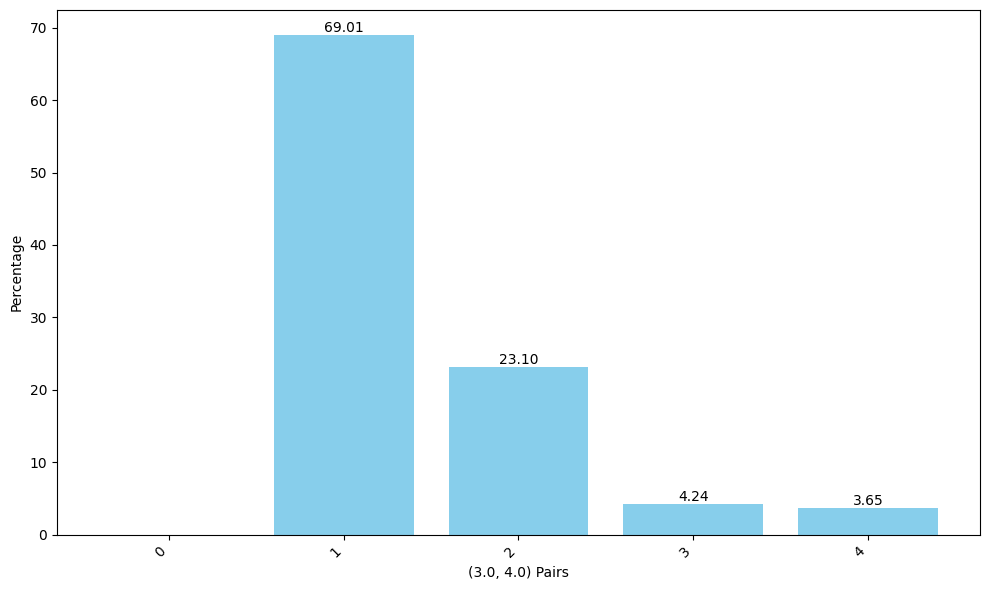

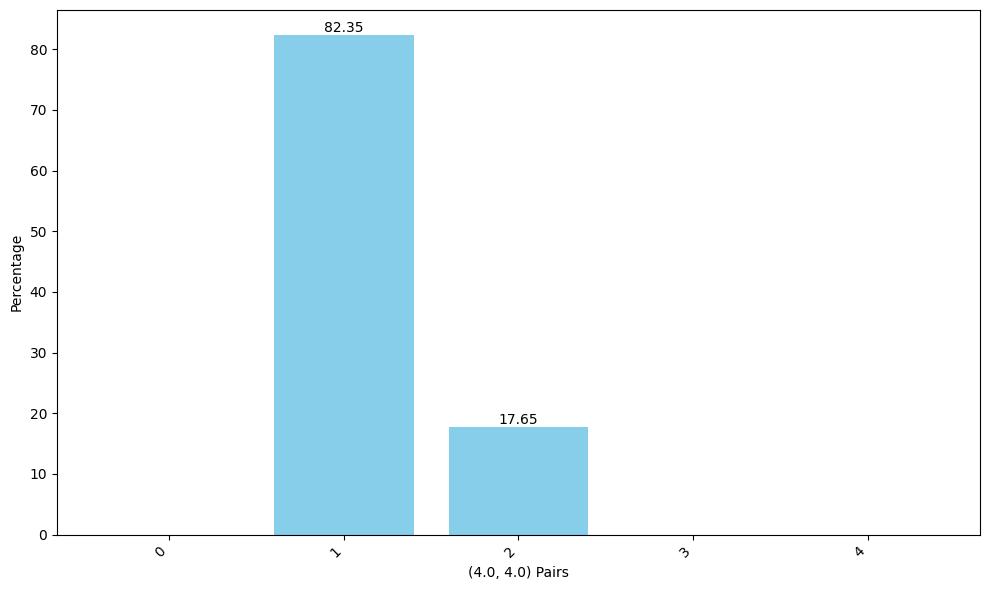

In [51]:
reporting(first_y_test, second_y_test, predicted_labels)


In [52]:
import numpy as np

unique_elements, counts = np.unique(pred, return_counts=True)
    
for element, count in zip(unique_elements, counts):
    print("Phần tử", element, "xuất hiện", count, "lần")


Phần tử 0 xuất hiện 852 lần
Phần tử 1 xuất hiện 18677 lần
Phần tử 2 xuất hiện 2396 lần
Phần tử 3 xuất hiện 661 lần
Phần tử 4 xuất hiện 282 lần
